# INTRODUCCIÓN A FloPy - Ejercicio 3

Modelo en planta de 2 capas, asignando condiciones de carga constate en las fronteras, recarga y pozos.

# Instalar paquetes

In [1]:
pip install flopy

Note: you may need to restart the kernel to use updated packages.


## Cargar paquetes

In [2]:
import os
#os.chdir(os.path.join(os.path.dirname(__file__)))
print(os.getcwd())
import flopy
#import plot_basic as pltb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Equipo\FloPy_1


# Configuración del modelo
Aquí se indican las rutas donde se encuentran los ejecutables, los archivos base y dónde se generarán los resultados de las simulaciones.

In [3]:
# Assigns the name and creates the object model MODFLOW
modelname = 'Ejercicio_planta'
exe_name="Exe/MODFLOW-NWT_64.exe"
model_ws='Results'
#mf1 = flopy.modflow.Modflow(modelname, exe_name="Exe/mf2005.exe", model_ws=model_ws)
mf1 = flopy.modflow.Modflow(modelname, exe_name=exe_name,model_ws=model_ws)


# Configuración de la geometría del modelo

In [4]:
Lx = 1000.
Ly = 1000.
# vector quecontiene la cota de fondo de las dos capas
zbot = [-50.,-100.]
Nlay = 2
nrow = 20
ncol = 20
rech=0.0005

ztop = np.ones((nrow, ncol), dtype=np.int32)

#Ciclo para asignar la cota del terreno
for i in range(ncol):
    ztop[:,i]=10-(0.5*i)
    
delr = Lx / ncol
delc = Ly / nrow


## Discretización del modelo

In [5]:
# https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html
dis = flopy.modflow.ModflowDis(mf1,Nlay,nrow,ncol,delr=delr,delc=delc,top=ztop,botm=zbot,itmuni=4,lenuni=2)      

[<AxesSubplot:title={'center':' model_top'}>,
 <AxesSubplot:title={'center':'botm layer 1'}>,
 <AxesSubplot:title={'center':'botm layer 2'}>]

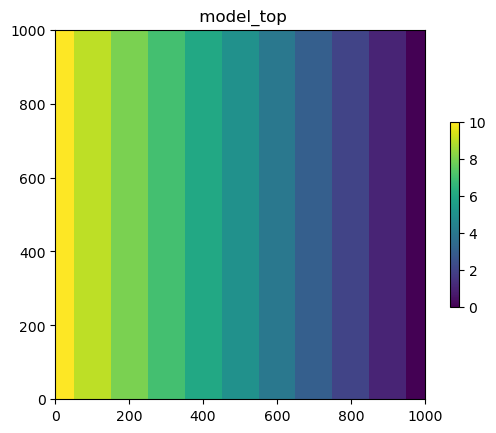

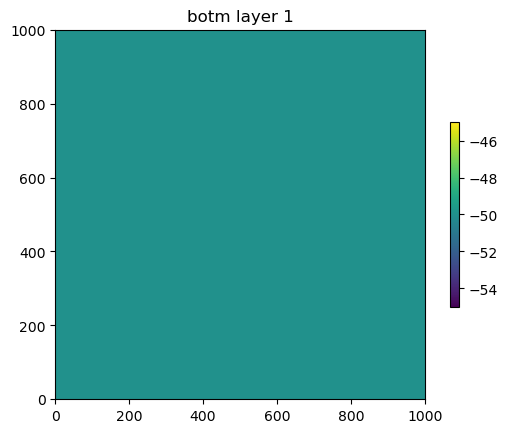

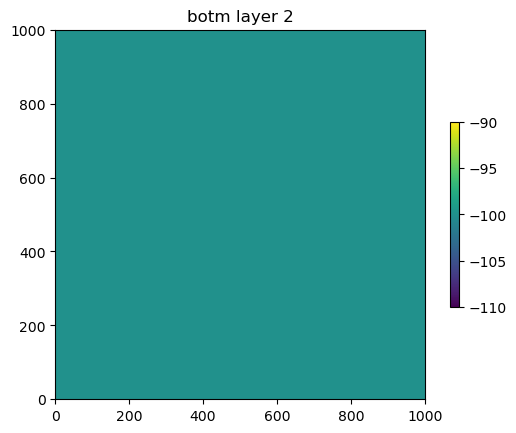

In [6]:
dis.plot()

## Condiciones de frontera

In [7]:
## Variable to package BAS
#ibound
ibound = np.ones((Nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
#Initial level
strt = np.ones((Nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf1, ibound=ibound, strt=strt)

[<AxesSubplot:title={'center':'ibound layer 1'}>,
 <AxesSubplot:title={'center':'ibound layer 2'}>,
 <AxesSubplot:title={'center':'strt layer 1'}>,
 <AxesSubplot:title={'center':'strt layer 2'}>]

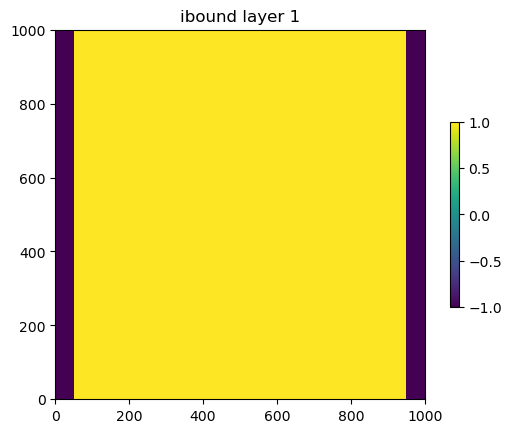

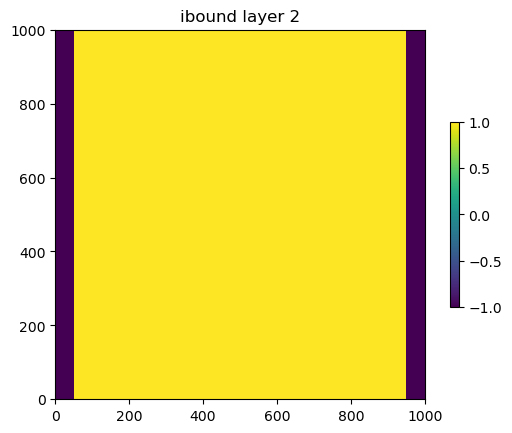

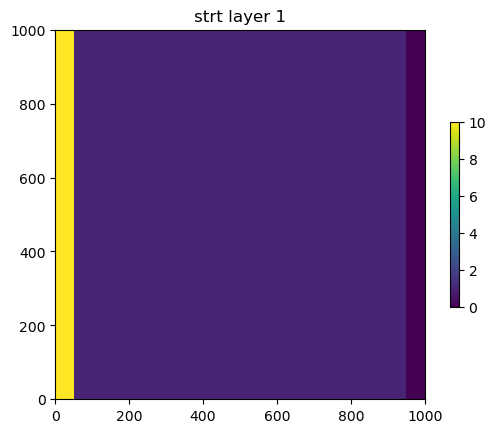

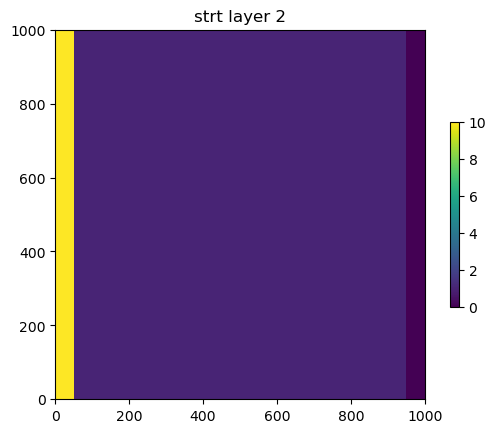

In [8]:
bas.plot()

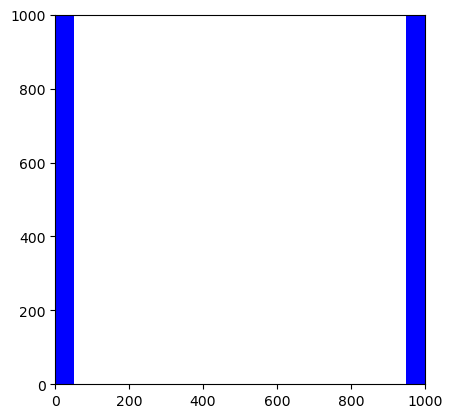

In [9]:
mapview = flopy.plot.PlotMapView(model=mf1)
quadmesh = mapview.plot_ibound()

In [10]:
mf1.bas6.check()



BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Asignar propiedades a los layers
Se crean los vectores que contienen las conductividades hidráulicas tanto horizontales como verticales para cada capa y se asigna el tipo de capa a trabajar (convertible o confinada) en laytyp.

In [11]:
#https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html
k=[0.1, 50]
vk = [0.01, 0.5]
lpf = flopy.modflow.ModflowLpf(mf1, hk=k, vka=vk, laytyp=[1, 0], ipakcb=53)

## Asignar una recarga

In [12]:
rch = flopy.modflow.ModflowRch(mf1,rech=rech)

## Asignar pozos
Es necesario crear un objeto tipo diccionario (spd). La llave o key "0" se refiere al periodo en la cual la condición de frontera se aplica.
En los parentesis cuadrados se asigna la capa (en python se numera desde 0, es decir, la capa 2 se asigna con 1), la fila (5), la columna (7), y la tasa de extracción (-150000).


[<AxesSubplot:title={'center':' WEL location stress period 1 layer 1'}>,
 <AxesSubplot:title={'center':' WEL location stress period 1 layer 2'}>]

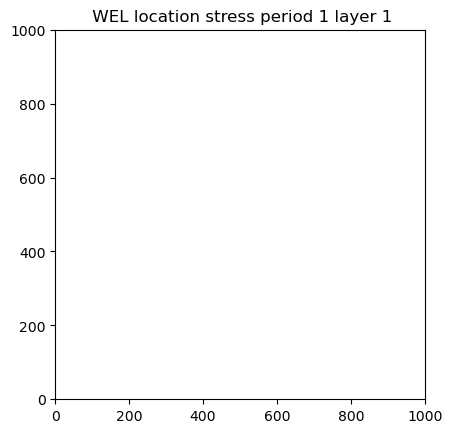

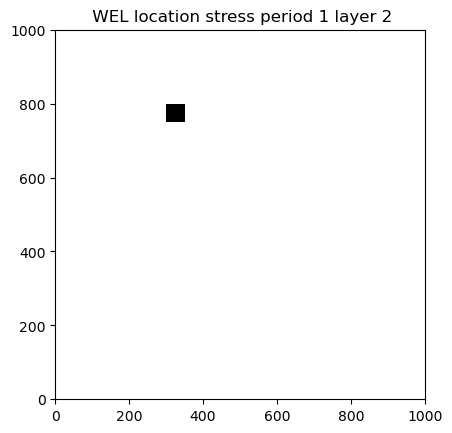

In [13]:
spd = {0:[[1, 4, 6 , -150000]]}
wel = flopy.modflow.ModflowWel(mf1,stress_period_data=spd)
wel.plot()

## Asignar ríos

#https://flopy.readthedocs.io/en/latest/source/flopy.modflow.mfriv.html

Utilizando el paquete RIVER, se genera el doccionario similar al pozo.

stress_period_data =
{0: [
    [lay, row, col, stage, cond, rbot],
    [lay, row, col, stage, cond, rbot],
    [lay, row, col, stage, cond, rbot]
    ],
1:  [
    [lay, row, col, stage, cond, rbot],
    [lay, row, col, stage, cond, rbot],
    [lay, row, col, stage, cond, rbot]
    ], ...

In [14]:
spd_riv={0: [[0, i, 19, 320, 1e5, -10] for i in range(nrow)]}
riv = flopy.modflow.ModflowRiv(mf1,stress_period_data=spd_riv)

[<AxesSubplot:title={'center':' RIV location stress period 1 layer 1'}>,
 <AxesSubplot:title={'center':' RIV location stress period 1 layer 2'}>]

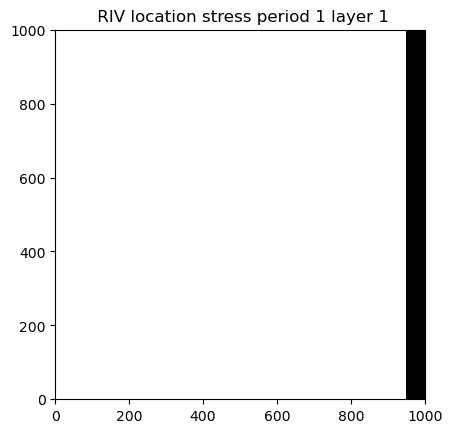

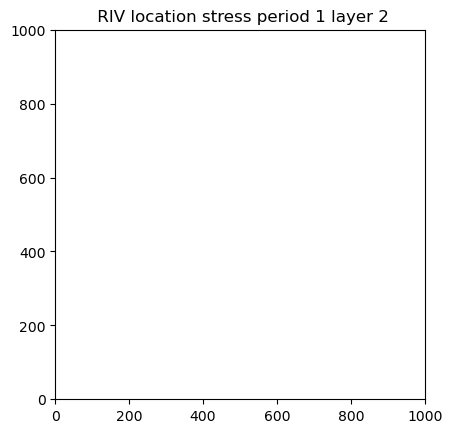

In [15]:
riv.plot()

In [16]:
#https://flopy.readthedocs.io/en/3.4.3/source/flopy.modflow.mfpcg.html
pcg = flopy.modflow.mfpcg.ModflowPcg(mf1, mxiter=100, iter1=60, hclose=1e-03, rclose=1e-03, relax=1.0) 
#The tuple "(0,0)" indicates that those changes will be applied for stress period 0 and time step 0
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget','save drawdown']}
oc = flopy.modflow.ModflowOc(mf1, stress_period_data=spd, compact=False)
mf1.write_input()
# mf1.check(level = 2)
success, buff = mf1.run_model()

FloPy is using the following executable to run the model: ..\Exe\MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: Ejercicio_planta.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/31 15:53:12

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/10/31 15:53:12
 Elapsed run time:  0.023 Seconds

  Normal termination of simulation


In [17]:
#%%Save and print Bugdet
from flopy.utils import MfListBudget

ml_list = MfListBudget('Results/'+modelname+'.list')
budget= ml_list.get_dataframes()
print(budget[0].T/86400) # day

                     1970-01-02
STORAGE_IN             0.000000
CONSTANT_HEAD_IN       1.735886
WELLS_IN               0.000000
RIVER_LEAKAGE_IN       0.000000
RECHARGE_IN            0.005208
TOTAL_IN               1.741094
STORAGE_OUT            0.000000
CONSTANT_HEAD_OUT      0.004983
WELLS_OUT              1.736111
RIVER_LEAKAGE_OUT      0.000000
RECHARGE_OUT           0.000000
TOTAL_OUT              1.741094
IN-OUT                 0.000000
PERCENT_DISCREPANCY    0.000000


# Cargas hidráulicas

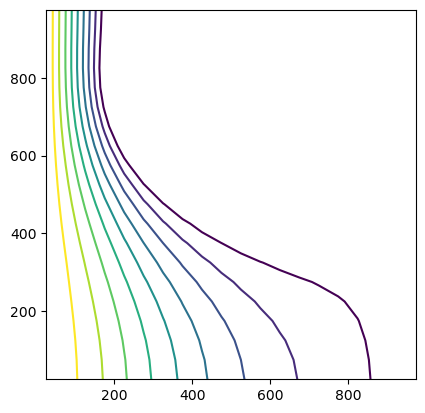

In [18]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
plt.subplot(1, 1, 1, aspect='equal')
hds = bf.HeadFile(model_ws+'/'+modelname + '.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(1, 10, 1)
extent = (delr / 2., Lx - delr / 2., Ly - delc / 2., delc / 2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
#Guardar figuras
#plt.savefig(model_ws+'/'+'sesion1_a.png')

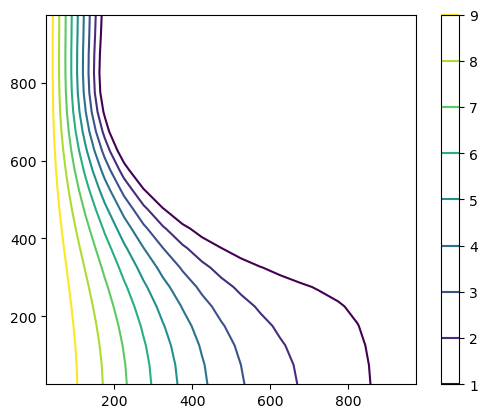

In [19]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
plt.subplot(1, 1, 1, aspect='equal')
hds = bf.HeadFile(model_ws+'/'+modelname + '.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(1, 10, 1)
extent = (delr / 2., Lx - delr / 2., Ly - delc / 2., delc / 2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
plt.colorbar()
#plt.savefig(model_ws+'/'+'Ex02_E1.png')

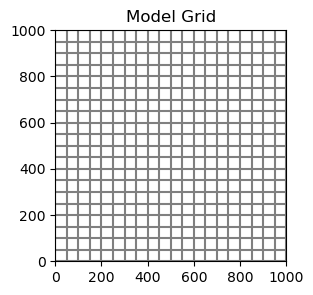

In [20]:
#Visualización malla
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf1)
linecollection = mapview.plot_grid()
t = ax.set_title("Model Grid")

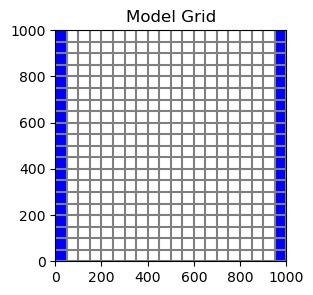

In [21]:
#Agregar las condiciones de frontera
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf1)
linecollection = mapview.plot_grid()
mapview.plot_ibound()
t = ax.set_title("Model Grid")

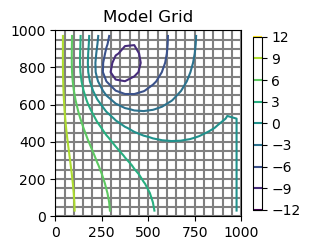

In [22]:
#Agregar isopiezas de la primera capa
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf1)
linecollection = mapview.plot_grid()
contour_set = mapview.contour_array(head[0, :, :])
t = ax.set_title("Model Grid")
plt.colorbar(contour_set, shrink=0.75)

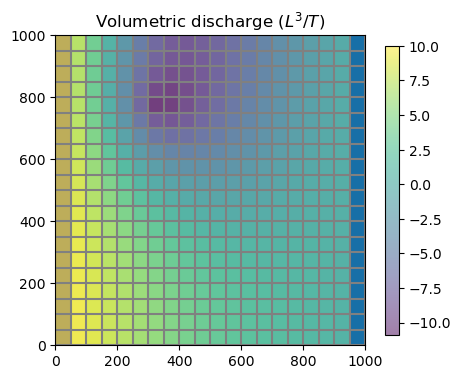

In [23]:
import os
fname = os.path.join(model_ws, modelname+'.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Volumetric discharge (' + r'$L^3/T$' + ')')
mapview = flopy.plot.PlotMapView(model=mf1)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head[0, :, :], alpha=0.5)
#quiver = mapview.plot_discharge(frf, fff)
linecollection = mapview.plot_grid()
plt.colorbar(quadmesh, shrink=0.75)

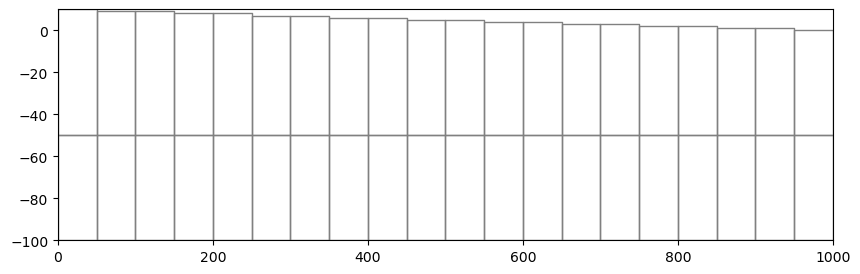

In [24]:
fig = plt.figure(figsize=(10, 3))
xsect = flopy.plot.PlotCrossSection(model=mf1, line={'Row': 3})
linecollection = xsect.plot_grid()
t = ax.set_title('Row 3 Cross-Section - Model Grid')

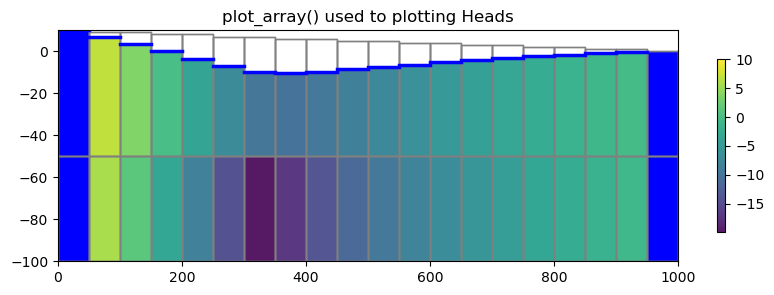

In [25]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('plot_array() used to plotting Heads')
xsect = flopy.plot.PlotCrossSection(model=mf1, line={'Row': 3})
pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.9)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
#plot the surface and model grid
wt = xsect.plot_surface(head[0], masked_values=[999.], color='blue', lw=2.5)
linecollection = xsect.plot_grid()
cb = plt.colorbar(pc, shrink=0.75)